In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
sber_data = pd.read_csv('data\sber_data.csv')
sber_data.drop(columns='id', inplace=True)

In [3]:
def outliers_iqr(df, feature, left=1.5, right=1.5):
    """
    Функция для определения выбросов по методу Тьюки.

    :param df: Исходный датафрейм
    :param feature: Фитча датафрейма для определения выбросов
    :param left: Множитель для определения левой границы выброса, по умолчанию 1.5
    :param right: Множитель для определения правой границы выброса, по умолчанию 1.5
    :return: Функция возвращает датафрейм с выбросами и отчищенный от выбросов датафрейм
    """

    x = df[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned


In [5]:
# Давайте ослабим границы метода Тьюки справа и усилим их влево. 
# Примените модифицированную функцию outliers_iqr() 
# к признаку full_sq из таблицы sber_data данным с параметрами left=1 и right=6. 
# Результаты работы поместите в переменные outliers и cleaned. 
# Чему равно результирующее число выбросов в данных?
outliers, cleaned = outliers_iqr(sber_data, 'full_sq', left=1, right=6)
outliers.shape[0]

59

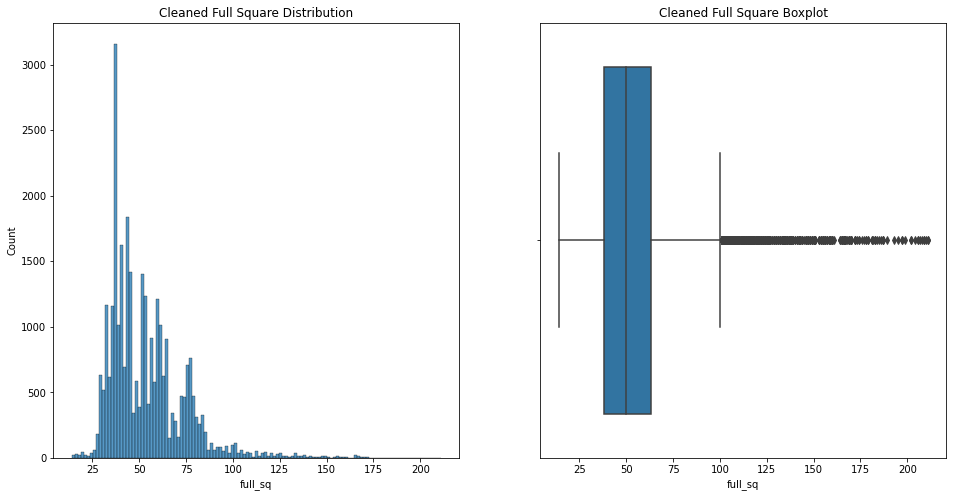

In [8]:
# Построим гистограмму и коробчатую диаграмму на полученных данных.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

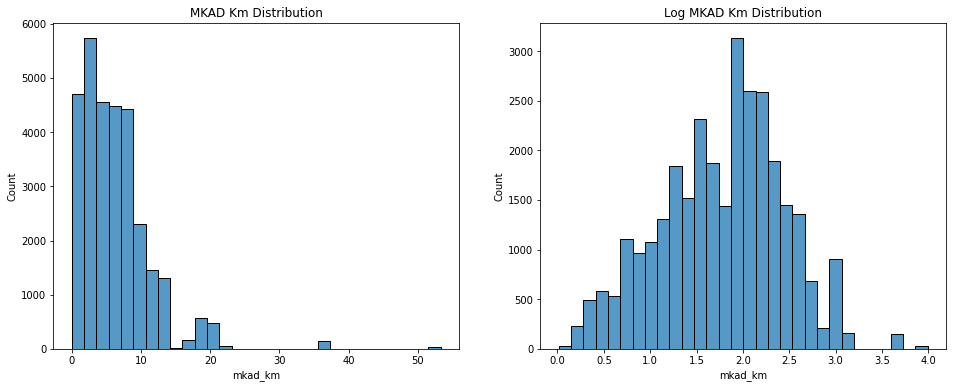

In [11]:
# Построим две гистограммы признака расстояния до МКАД (mkad_km): 
# первая — в обычном масштабе, а вторая — в логарифмическом. 
# Логарифмировать будем с помощью функции log() из библиотеки 
# numpy (натуральный логарифм — логарифм по основанию числа e). 
# Признак имеет среди своих значений 0. Из математики известно, 
# что логарифма от 0 не существует, поэтому мы прибавляем к нашему признаку 1, 
# чтобы не логарифмировать нули и не получать предупреждения.

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

In [25]:
def outliers_z_score(df, feature, log_scale=False):
    """
    Функция для определения выбросов по методу 3х сигм

    :param df: Исходный датафрейм
    :param feature: Фитча датафрейма для определения выбросов
    :param log_scale: Нужно ли логарифмировать рассмативаемый признак
    :return: Функция возвращает датафрейм с выбросами и отчищенный от выбросов датафрейм
    """

    current_series = df[feature]

    if log_scale:
        # Если в серии минимальное значение 0,
        # то небходимо добавить 1 во всю серии, т.к. логарифм от 0 невозможен
        current_series = np.log(current_series + 1)

    mu = current_series.mean()
    sigma = current_series.std()

    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma

    outliers = df[(current_series < lower_bound) | (current_series > upper_bound)]
    cleaned = df[(current_series > lower_bound) & (current_series < upper_bound)]

    return outliers, cleaned

In [26]:
# Применим эту функцию к таблице sber_data и признаку mkad_km, а также выведем размерности результатов
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438


In [27]:
# В каких районах (sub_area) представлены эти квартиры
outliers['sub_area'].unique()

array(['Poselenie Rogovskoe', 'Poselenie Kievskij'], dtype=object)

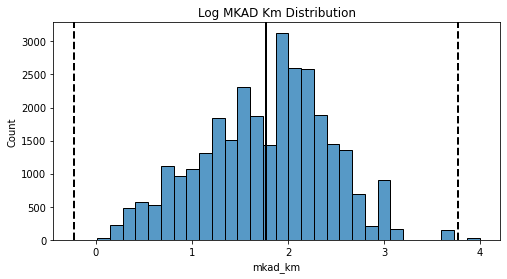

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean() + 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean() - 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

In [47]:
def outliers_z_score_mod(df, feature, log_scale=False, left=3, right=3):
    """
    Функция для определения выбросов по методу 3х сигм

    :param df: Исходный датафрейм
    :param feature: Фитча датафрейма для определения выбросов
    :param log_scale: Нужно ли логарифмировать рассмативаемый признак
    :return: Функция возвращает датафрейм с выбросами и отчищенный от выбросов датафрейм
    """

    current_series = df[feature]

    if log_scale:
        # Если в серии минимальное значение 0,
        # то небходимо добавить 1 во всю серии, т.к. логарифм от 0 невозможен
        current_series = np.log(current_series + 0)

    mu = current_series.mean()
    sigma = current_series.std()

    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma

    outliers = df[(current_series < lower_bound) | (current_series > upper_bound)]
    cleaned = df[(current_series > lower_bound) & (current_series < upper_bound)]

    return outliers, cleaned

In [33]:
# Проверьте, что будет, если дать «послабление» вправо, увеличив число сигм. 
# Наша задача — узнать, начиная с какой границы поселения «Роговское» и «Киевское» перестают считаться выбросами. 
# Примените свою функцию outliers_z_score_mod() к признаку mkad_km с параметрами left=3, right=3.5, log_scale=True. 
# Чему равно результирующее число выбросов?
outliers, cleaned = outliers_z_score_mod(sber_data, 'mkad_km', log_scale=True, left=3, right=3.5)

In [34]:
outliers.shape[0]

0

In [36]:
sber_data['price_doc'].min()

100000

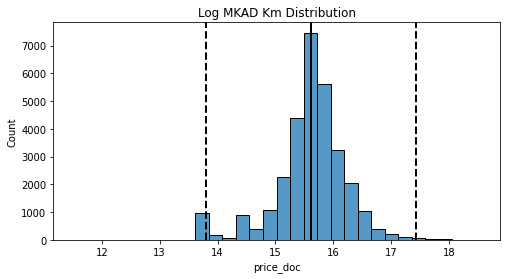

In [37]:
# Постройте гистограмму для признака price_doc в логарифмическом масштабе. 
# А также, добавьте на график линии, отображающие среднее и границы интервала для метода трех сигм.
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_price_doc = np.log(sber_data['price_doc'])
histplot = sns.histplot(log_price_doc, bins=30, ax=ax)

mean_price = log_price_doc.mean()
std_price = log_price_doc.std()

histplot.axvline(mean_price, color='k', lw=2)
histplot.axvline(mean_price + 3 * std_price, color='k', ls='--', lw=2)
histplot.axvline(mean_price - 3 * std_price, color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');


In [42]:
# Найдите потенциальные выбросы с помощью метода z-отклонения. Используйте логарифмический масштаб распределения. 
# Сделайте «послабление» на 0.7 сигм в в обе стороны распределения. 
# Сколько выбросов вы получили?
outliers, cleaned = outliers_z_score_mod(sber_data, 'price_doc', log_scale=True, left=3.7, right=3.7)

In [43]:
outliers.shape[0]

52

In [52]:
# Добавьте фишку с логарифмированием в свою функцию outliers_iqr_mod(). 
# Добавьте в неё параметр log_scale. Если он выставлен в True, 
# то производится логарифмирование признака. Примените полученную функцию к признаку price_doc. 
# Число межквартильных размахов в обе стороны обозначьте как 3. 
# Чему равно число выбросов, полученных таким методом?

def outliers_iqr(df, feature, log_scale=False, left=1.5, right=1.5):
    """
    Функция для определения выбросов по методу Тьюки.

    :param df: Исходный датафрейм
    :param feature: Фитча датафрейма для определения выбросов
    :param log_scale: Нужно ли логарифмировать рассмативаемый признак
    :param left: Множитель для определения левой границы выброса, по умолчанию 1.5
    :param right: Множитель для определения правой границы выброса, по умолчанию 1.5
    :return: Функция возвращает датафрейм с выбросами и отчищенный от выбросов датафрейм
    """

    x = df[feature]
    
    if log_scale:
        x = np.log(x)
        
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned


In [53]:
outliers, cleaned = outliers_iqr(sber_data, 'price_doc', log_scale=True, left=3, right=3)
outliers.shape[0]

92

In [1]:
#############